A demonstration of accessing files containing DESI mass spectrometry data. Demonstrates data access both for MATLAB files generated from the old Bruker instrument file conversion method, as well as the binary files generated from the more direct method with the Agilent instrument.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy.spatial import distance_matrix

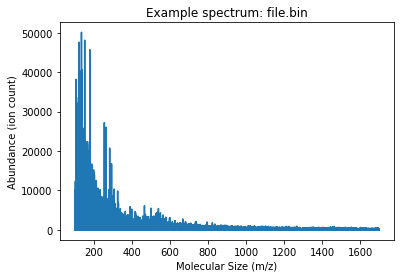

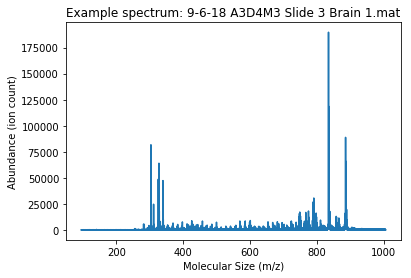

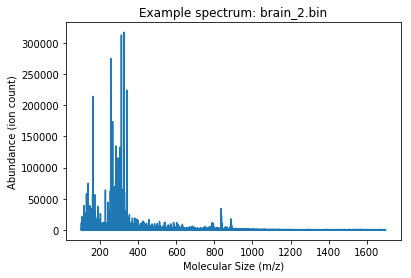

Unable to open mattest.mat


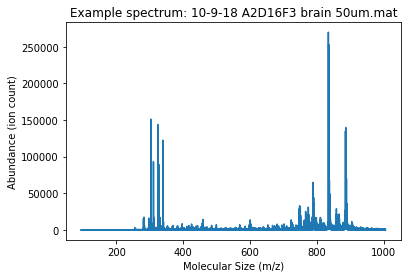

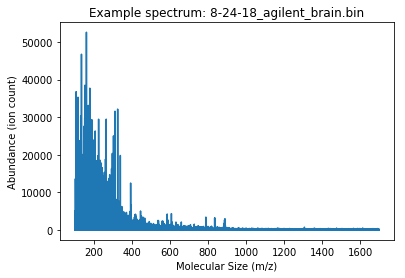

In [2]:
# Initialize values, including column dict's for Pandas DataFrame
directory = '../../DESI Data'
images = []
file_properties = {
    'File':[],
    'Z-axis':[],
    'X_size': [],
    'Y_size': [],
    'Z_size': []
}
spectra = {
    'X_coordinate': [],
    'Y_coordinate': [],
    'Original Spectrum': [],
    'Mean-adjusted Spectrum': [],
    'Source File': []
}

# Read in data from appropriate file format for each file in a directory
for file in os.listdir(directory):
    # Initialize data container variables
    image, z_axis = None, None
    x, y, z = None, None, None
    
    try:
        # Handle standard binary files (Agilent)
        if file.endswith('.bin'):
            f = open(directory + '/' + file, 'rb')
            data = np.fromfile(f, '<f4')
            x, y, z = [int(n) for n in data[:3]]
            image, z_axis = data[3:x*y*z + 3], data[-z:]
            image.shape = (y, x, z)
            image = image.transpose((1, 0, 2))

        # Handle MATLAB binary files (Bruker)
        elif file.endswith('.mat'):
            data = {}
            f = h5py.File(directory + '/' + file, 'r')
            for k, v in f.items():
                data[k] = np.array(v)
            image, z_axis = data['img'], data['imgZ'][0]
            x, y, z = [len((data[x] if x != 'imgZ' else data[x].T))
                    for x in ['imgX', 'imgY', 'imgZ']]
            image.shape = (z, x, y)
            image = image.transpose((1, 2, 0))

    except:
        print("Unable to open", file)
        continue
    
    # Assign properties to column names in dict
    file_properties['File'].append(file)
    file_properties['Z-axis'].append(z_axis)
    file_properties['X_size'].append(x)
    file_properties['Y_size'].append(y)
    file_properties['Z_size'].append(z)
    
    # Add image to list, and get converted versions of the image
    images.append(image)
    int_image = image.astype(int)
    mean_adjusted_image = image/np.mean(image)
    random_spectrum = (np.random.randint(x), np.random.randint(y))

    # Iterate through each pixel in each row and column
    for i in range(x):
        for j in range(y):
            # Add individual spectrum parameters to dict
            spectra['X_coordinate'].append(i+1)
            spectra['Y_coordinate'].append(j+1)
            spectra['Original Spectrum'].append(int_image[i][j])
            spectra['Mean-adjusted Spectrum'].append(mean_adjusted_image[i][j])
            spectra['Source File'].append(file)
            
            # Plot the spectrum for a random pixel
            if i == random_spectrum[0] and j == random_spectrum[1]:
                plt.plot((z_axis if file != 'brain_2.bin' else z_axis[:-18]),
                        (int_image[i][j] if file != 'brain_2.bin' else int_image[i][j][:-18]))
                plt.title('Example spectrum: ' + file)
                plt.xlabel('Molecular Size (m/z)')
                plt.ylabel('Abundance (ion count)')
                plt.show()

In [3]:
# Save the data to Pandas DataFrames
spectra_data_frame = pd.DataFrame(data=spectra)
file_properties_data_frame = pd.DataFrame(data=file_properties)